#### IMPORTING LIBRARIES

In [0]:
import os
import re
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
seed = 42

### Importing Dataset

In [0]:
dataframe =  pd.read_csv('HTL.csv').dropna()

In [3]:
dataframe

,text,polarity
0,المكان الذي يمكنك فيه مراجعة الذات والتفكر هو ...,1
1,موقع رائع وحديقة رائعة ويستحق نجمةّ إضافية \r...,0
2,أسوأ فندق أقمت فيه على الإطلاق \r\nيستغرق تسج...,-1
3,بدون روح كأنه فندق ثلاثة نجوم \r\nبدون إدارة ...,0
4,فندق جميل مع سوء الإدارة والخدمات. \r\nمن الخ...,-1
...,...,...
15567,قريب من كل شي \r\nجميل وهادي وكل شي حولك حتي ا...,1
15568,فندق رائع وممتاز \r\nلقد نزلت بتاريخ 1/12/2013...,1
15569,جيد \r\nالفندق بشكل عام ميزته أنه يقع قرب مركز...,0
15570,احقر مكان على وجه الارض \r\nانصح كل الذين يقوم...,-1


#### Include positive and negative reviews

In [0]:
dataframe = dataframe[dataframe.polarity.isin([-1, 1])]

In [5]:
dataframe

,text,polarity
0,المكان الذي يمكنك فيه مراجعة الذات والتفكر هو ...,1
2,أسوأ فندق أقمت فيه على الإطلاق \r\nيستغرق تسج...,-1
4,فندق جميل مع سوء الإدارة والخدمات. \r\nمن الخ...,-1
5,فندق جميل، منظر رائع من بركة السباحة (على السط...,1
6,مكان لطيف وهادئ بعيدًا عن الزحام \r\nعثرت على...,1
...,...,...
15566,عطلة رائعة في نهاية الأسبوع \r\nإقامة جميلة و...,1
15567,قريب من كل شي \r\nجميل وهادي وكل شي حولك حتي ا...,1
15568,فندق رائع وممتاز \r\nلقد نزلت بتاريخ 1/12/2013...,1
15570,احقر مكان على وجه الارض \r\nانصح كل الذين يقوم...,-1


#### Cleaning Data

In [0]:
def clean_data(text):

  search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى",
              "\\",'\n', '\t','&quot;','?','؟','!']
  replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","ي","",' ', ' ',' ',' ? ',' ؟ ', ' ! ']
  tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(tashkeel,"", text)
  longation = re.compile(r'(.)\1+')
  subst = r"\1\1"
  text = re.sub(longation, subst, text)
  text = re.sub(r"[^\w\s]", '', text)
  text = re.sub(r"[a-zA-Z]", '', text)
  text = re.sub(r"\d+", ' ', text)
  text = re.sub(r"\n+", ' ', text)
  text = re.sub(r"\t+", ' ', text)
  text = re.sub(r"\r+", ' ', text)
  text = re.sub(r"\s+", ' ', text)
  text = text.replace('وو', 'و')
  text = text.replace('يي', 'ي')
  text = text.replace('اا', 'ا')
  for i in range(0, len(search)):
     text = text.replace(search[i], replace[i])
    
  text = text.strip()
  return text

In [7]:
dataframe['cleaned_text'] = dataframe.text.apply(clean_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
dataframe.head(10)

,text,polarity,cleaned_text
0,المكان الذي يمكنك فيه مراجعة الذات والتفكر هو ...,1,المكان الذي يمكنك فيه مراجعه الذات والتفكر هو ...
2,أسوأ فندق أقمت فيه على الإطلاق \r\nيستغرق تسج...,-1,اسوا فندق اقمت فيه علي الاطلاق يستغرق تسجيل ال...
4,فندق جميل مع سوء الإدارة والخدمات. \r\nمن الخ...,-1,فندق جميل مع سوء الاداره والخدمات من الخارج بد...
5,فندق جميل، منظر رائع من بركة السباحة (على السط...,1,فندق جميل منظر رائع من بركه السباحه علي السطح ...
6,مكان لطيف وهادئ بعيدًا عن الزحام \r\nعثرت على...,1,مكان لطيف وهادئ بعيدا عن الزحام عثرت علي هذا ا...
7,"راقي و كلاسيكي"" \r\nفندق كبير مصمم بفن الديكو...",1,راقي وكلاسيكي فندق كبير مصمم بفن الديكور الجمي...
8,تحذير للرجال الذي يحبون تناول بعض البيرة ليلاً...,1,تحذير للرجال الذي يحبون تناول بعض البيره ليلا ...
9,فندق رائع \r\nبعد 4 أيام قضيناها في ليسبوا، و...,1,فندق رائع بعد ايام قضيناها في ليسبوا وصلنا اخي...
10,ساحر \r\nإذا كنت تتوق إلى تجربة فريدة، عليك ب...,1,ساحر اذا كنت تتوق الي تجربه فريده عليك بتجربه ...
11,هناك بعض الإحباطات ولكن الغرف كانت رائعة والمو...,1,هناك بعض الاحباطات ولكن الغرف كانت رائعه والمو...


#### Balancing Data
#### Equal Pos and Neg reviews

In [9]:
min_sample = dataframe.groupby(['polarity']).count().text.min()
input_data = pd.concat([dataframe[dataframe.polarity == 1].head(min_sample), dataframe[dataframe.polarity == -1].head(min_sample)])
input_data.groupby(['polarity']).count()

,text,cleaned_text
polarity,,
-1,2647,2647
1,2647,2647


### Creating Numpy Arrays of Data

In [0]:
X = input_data.cleaned_text.values

In [11]:
X

array(['المكان الذي يمكنك فيه مراجعه الذات والتفكر هو كوكروبيت غانا ثمه الكثير عند زياره غانا وعلي الرغم من الفقر الذي سوف تلاحظه علي طريقك الي بيغ ميلي باكيارد وجدت ان الناس في غانا يملكون ثراء القلب حتي رغم العوز بيغ ميلي باكيارد هو مكان يمكنني فيه مراجعه الذات والتفكر التقيت اشخاصا كانوا يعملون علي مبادرات مختلفه بيغ ميلي هو مكان يمكننا فيه تبادل الملاحظات والاراء بيغ ميلي مليء بالسلام وهادئ للغايه الطعام ممتاز جدا الطهاه ممتازون وبالاضافه الي ذلك لا بد من الاشاره الي ان العمال الذين لا يكلون ويحرصون علي سعاده نزلائهم هم من يجعلون المكان مضيافا هناك خيبه امل واحده كبيره رغم ان الفنون والاشغال اليدويه يمكن شراؤها في الموقع الا ان الاسعار غاليه مؤخرا ازالت السلطات في كوكروبيت محلات التجار الواقعه خارج شاطئ بيغ ميلي كانت منتجات التجار ارخص لا يزال هناك محل تجاري متجر مايسترو للفن الافريقي في كوكروبيت يعرض الفنون والاشغال اليدويه الفريده والملابس واللوحات اشتريت لوحات مذهله لايمكنك ان تجدها في بيغ ميلي عندما تزور بيغ ميلي من فضلك خذ لحظه للذهاب الي الشاطئ وعلي يمينك ستجد متجر مايسترو لل

In [0]:
Y = np.asarray(input_data.polarity.values).astype('float32')
Y = Y.clip(0, 1)

In [13]:
Y

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

#### Creating Sequences

In [14]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

vocab_size = len(tokenizer.word_index) + 1
print("vocab size:", vocab_size)

vocab size: 48682


In [0]:
maxlen = 300
X = pad_sequences(X, padding='post', maxlen=maxlen)

#### Splitting Data into train and Test 

In [0]:
X_train, X_test, label_train, label_test = train_test_split(X, Y, test_size=0.1,
                                                            random_state=seed)

In [17]:
print("Training:", len(X_train), len(label_train))
print("Testing: ", len(X_test), len(label_test))

Training: 4764 4764
Testing:  530 530


#### Using Bidirectional LSTM

In [18]:
embedding_dim = 100
dropout = 0.5
optimizer = 'adam'
clear_session()

model = Sequential()
model.add(layers.Embedding(input_dim=num_words,output_dim=embedding_dim,input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(100,dropout=dropout,recurrent_dropout=dropout,return_sequences=True)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 200)          160800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25728     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
____________________________________

In [20]:
history = model.fit(X_train, label_train, epochs = 50, verbose=True, validation_data=(X_test,label_test), batch_size=64,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])




Train on 4764 samples, validate on 530 samples
Epoch 1/50





4764/4764 [==============================] - 112s 24ms/step - loss: 0.6924 - acc: 0.5069 - val_loss: 0.6907 - val_acc: 0.5283
Epoch 2/50
4764/4764 [==============================] - 100s 21ms/step - loss: 0.6045 - acc: 0.6711 - val_loss: 0.3118 - val_acc: 0.9057
Epoch 3/50
4764/4764 [==============================] - 99s 21ms/step - loss: 0.3586 - acc: 0.8887 - val_loss: 0.2161 - val_acc: 0.9302
Epoch 4/50
4764/4764 [==============================] - 99s 21ms/step - loss: 0.2203 - acc: 0.9372 - val_loss: 0.1547 - val_acc: 0.9358
Epoch 5/50
4764/4764 [==============================] - 99s 21ms/step - loss: 0.1279 - acc: 0.9641 - val_loss: 0.1558 - val_acc: 0.9396
Epoch 6/50
4764/4764 [==============================] - 99s 21ms/step - loss: 0.0911 - acc: 0.9746 - val_loss: 0.1504 - val_acc: 0.9340
Epoch 7/50
4764/4764 [==============================] - 98s 21ms/step - loss: 0.0556 - acc: 0.9866 - val_loss: 0.1733 - val_acc

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


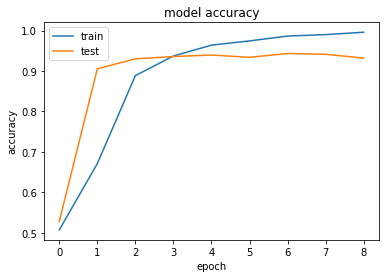

In [21]:
import matplotlib.pyplot as plt
# summarize history for accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

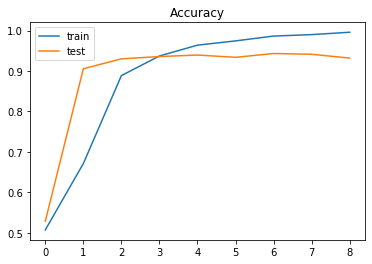

In [22]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

#### Saving Model

In [0]:
import pickle
filename = 'arabic_tokenizer.pkl'
pickle.dump(tokenizer, open(filename, 'wb'))

#### Testing Models

##### Blind Data

In [0]:
blind_sample = 200
blind_test = pd.concat([dataframe[dataframe.polarity == 1].tail(blind_sample), 
                        dataframe[dataframe.polarity == -1].tail(blind_sample)])

In [0]:
X_blind = blind_test.cleaned_text.values
Y_blind = np.asarray(blind_test.polarity.values).astype('float32')
Y_blind = Y_blind.clip(0, 1)

In [28]:
X_blind[1]

'ارفع اسعارك يالها من قيمه عظيمه مقابل ما تدفعه من مال دولار استرالي لليله الواحده ويتضمن افطارا مطبوخا ممتازا مئتا متر سيرا علي الاقدام الي الشاطئ ومطعم كازوما من ارخص وافضل الاكلات البحريه الطازجه التي وجدناها في بالي يمكنك استئجار دراجه دفع علي الشاطئ ثم تركبها الي البارات والمتاجر الرئيسيه علي طول مقدمه الشاطئ سافرنا مع زوجين اخرين وعند الوصول من الافضل طباعه الخارطه لان الاتجاهات قد تربك سائقي بالي قليلا رحب بنا بحراره رون وايرما وقدموا لنا مشروب بينتانغ البارد وهو ترحاب يتوقعه المرء من صديق مفتقد لفتره طويله الجو الغير رسمي في فيلات سانور بيتش يذكر المرء بالبيت واذا كان لدي رون بعض الوقت عليك ان تجرب واحده من جولاته الثقافيه المشهوره الفيلات كما هو مذكور في الاراء السابقه نظيفه واسعه كانت الثلاجه رائعه ولكن مع وجود صندوق التبريد بيغريد اسكي تحت شجره المعرفه لم يكن ثمه حاجه لها كنا قد لا تحتاج الي هذا ابرد مشروب بينتانغ في الجزيره كان لدينا ازواج اخرين انضموا الينا من كوتا لفتره ما بعد الظهر وهم يخططون منذ الان لرحلتهم القادمه الي بالي وفيلات سانور بيتش هي في اول قائمه اماكن الاقا

##### Text to sequences

In [0]:
X_blind = tokenizer.texts_to_sequences(X_blind)
X_blind = pad_sequences(X_blind, padding='post', maxlen=maxlen)

##### Predicting

In [30]:
pred_blind = model.predict(X_blind, verbose=True)

400/400 [==============================] - 6s 16ms/step


##### ***Comparing*** *Results*

In [0]:
df_blind = pd.DataFrame({'REAL': Y_blind, 
                         'PRED': pred_blind.reshape(pred_blind.shape[0],), 
                         'TEXT': blind_test.cleaned_text})
df_blind = df_blind.reset_index()[['REAL', 'PRED', 'TEXT']]
df_blind.PRED = df_blind.PRED.round()
error_records = df_blind[df_blind.REAL != df_blind.PRED]

In [32]:
print("Number of misclassified reviews: {} out of {}".format(error_records.shape[0], df_blind.shape[0]))
print("Blind Test Accuracy:  {:.4f}".format(accuracy_score(df_blind.REAL, df_blind.PRED)))

Number of misclassified reviews: 49 out of 400
Blind Test Accuracy:  0.8775


In [33]:
df_blind.sample(n=5)

,REAL,PRED,TEXT
16,1.0,1.0,متعه غير كبيره نوعا ما ان هذا الفرع من فندق با...
157,1.0,1.0,موقع عظيم قيمه واهميه كبيره يقع بعد دقائق فقط ...
160,1.0,1.0,فندق رائع لقد استمتعنا بهذا المكان كثيرا كانت ...
397,0.0,0.0,موظفون بشعون وغرفه بشعه انج بنفسك ابتعد ياالهي...
268,0.0,0.0,لا شكرا لا اصدق انني اقيم في نفس المكان مثل كل...
